In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

import models
import plotting
import utils.dataloaders as dl
import traintest as tt
import adversarial as adv

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
base_model = torch.load('SavedModels/base_model.pth').to(device)
gmm_model = torch.load('SavedModels/gmm_model.pth').to(device)

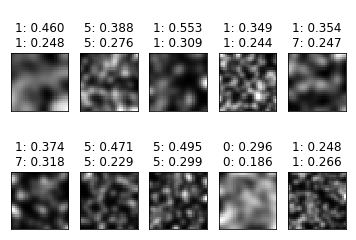

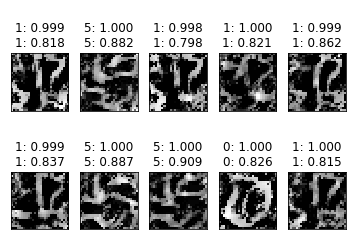

In [6]:
data = enumerate(dl.Noise_loader).__next__()[1][0]

y_base = base_model(data.to(device))
y = gmm_model(data.to(device))

plotting.plot_samples([y_base, y], data.detach().cpu())

data = adv.gen_adv_noise(base_model, device, data, epsilon=0.3, step_size=0.01)

y_base = base_model(data.to(device))
y = gmm_model(data.to(device))

plotting.plot_samples([y_base, y], data.detach().cpu())

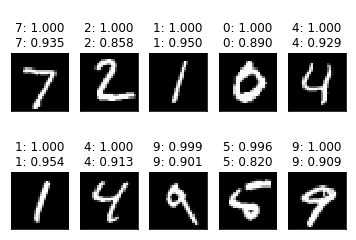

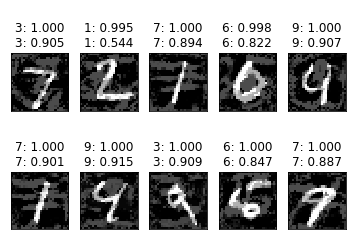

In [7]:
data, label = enumerate(dl.MNIST_test_loader).__next__()[1]

y_base = base_model(data.to(device))
y = gmm_model(data.to(device))

plotting.plot_samples([y_base, y], data.detach().cpu())

data = adv.gen_adv_sample(base_model, device, data, label, epsilon=0.3, step_size=0.01)

y_base = base_model(data.to(device))
y = gmm_model(data.to(device))

plotting.plot_samples([y_base, y], data.detach().cpu())

In [103]:
import torch

lr = .0001
momentum = .9

#optimizer = optim.SGD([{"params":robust_model.gmm.parameters()}, {"params":robust_model.log_pz_lam}], lr=lr, momentum=momentum)

#optimizer = optim.SGD(robust_model.gmm.parameters(), lr=lr, momentum=momentum)
optimizer = optim.SGD([gmm_model.mm.alpha, robust_model.mm.logvar], lr=lr, momentum=momentum)


for epoch in range(2):
    optimizer.param_groups[0]['lr'] *= .8
    tt.train_adv(gmm_model, device, dl.train_loader, optimizer, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.774529
Train Epoch: 0 [10000/60000 (17%)]	Loss: 1.372429
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.351294
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.374229
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.330523
Train Epoch: 0 [50000/60000 (83%)]	Loss: 1.340730
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.340102
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.323793
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.295429
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.326414
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.320783
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.303746


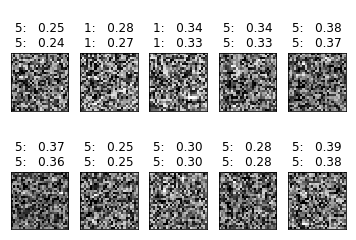

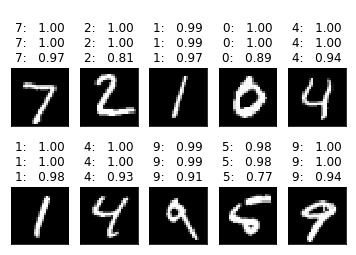

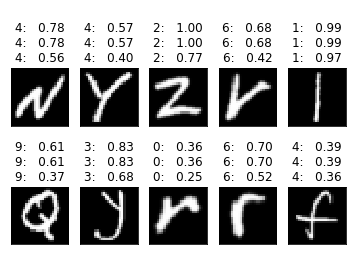

In [131]:


gmm_model.eval()

perturbed_image = tt.generate_adv_noise(gmm_model.base_model, 3., device=device)

y = gmm_model(perturbed_image.to(device))
y_base = base_model(perturbed_image.to(device))

plotting.plot_samples([y_base, y], perturbed_image.cpu())


data = enumerate(dl.test_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y2 = qmm_model.base_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y_base, y2, y], data)


data = enumerate(dl.EMNIST_test_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y2 = qmm_model.base_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y_base, y2, y], data)


In [143]:
min_conf = .4
tt.test(gmm_model, device, dl.test_loader, min_conf = min_conf)
tt.test(qmm_model, device, dl.test_loader, min_conf = min_conf)
tt.test(base_model, device, dl.test_loader, min_conf = min_conf)


Test set: Average loss: 0.1464, Accuracy: 9867/10000 (99%), Ave. Confidence: 88%


Test set: Average loss: 0.6139, Accuracy: 9770/10000 (98%), Ave. Confidence: 55%


Test set: Average loss: 0.0353, Accuracy: 9890/10000 (99%), Ave. Confidence: 98%



(9890, 0.9806158889770508)

In [144]:
tt.test_adv(gmm_model, device, dl.EMNIST_test_loader, min_conf = min_conf)
tt.test_adv(qmm_model, device, dl.EMNIST_test_loader, min_conf = min_conf)
tt.test_adv(base_model, device, dl.EMNIST_test_loader, min_conf = min_conf)


Ave. Confidence: 55% Predicted: 71%


Ave. Confidence: 46% Predicted: 69%


Ave. Confidence: 79% Predicted: 96%



0.7870442313414353

In [8]:
def bound(L, model):
    xi = (model.mm.calculate_bound(L)-model.loglam).exp()
    return .1*(1+10*xi)/(1+xi)

def visualize_bound(model, lamv, xv=np.linspace(0., 16.,15)):
    with torch.no_grad():
        temp_lam = model.loglam.data
        n = 1
        data = []
        for _ in range(n):
            data.append(enumerate(dl.test_loader).__next__()[1][0])
        data_MNIST = torch.cat(data, dim=0)
        Lm = (data_MNIST.view(n*100,784)[:,None,:]-dl.X_MNIST[None,:,:]).norm(dim=2).min(dim=1)[0]

        data = []
        for _ in range(n):
            data.append(enumerate(dl.EMNIST_train_loader).__next__()[1][0])
        data_EMNIST = torch.cat(data, dim=0)
        Le = (data_EMNIST.view(n*100,784)[:,None,:]-dl.X_MNIST[None,:,:]).norm(dim=2).min(dim=1)[0]

        data = []
        for _ in range(n):
            data.append(enumerate(dl.fashion_train_loader).__next__()[1][0])
        data_FMNIST = torch.cat(data, dim=0)
        Lf = (data_FMNIST.view(n*100,784)[:,None,:]-dl.X_MNIST[None,:,:]).norm(dim=2).min(dim=1)[0]

        plt.figure(figsize=(15,8))


        for i, lam in enumerate(lamv):
            plt.subplot(2,len(lamv),i+1)
            model.loglam.data = torch.tensor(lam, device=device)
            plt.plot(xv, [bound(x, model) for x in xv] )

            y = model(data_MNIST.to(device)).max(dim=1)[0].exp()
            ms = plt.scatter(Lm.detach(),y.detach().cpu().numpy(),alpha=.8, marker='+')

            y = model(data_EMNIST.to(device)).max(dim=1)[0].exp()
            es = plt.scatter(Le.detach(),y.detach().cpu().numpy(),alpha=.8, marker='+')

            y = model(data_FMNIST.to(device)).max(dim=1)[0].exp()
            fs = plt.scatter(Lf.detach(),y.detach().cpu().numpy(),alpha=.8, marker='+')
            
            plt.title('loglambda='+str(lam))
            plt.xlabel('L=min_k d(mu_k,x)')
            plt.ylabel('max_c p(y=c|x)')
            plt.legend(( ms, es, fs),
                       ('MNIST', 'EMNIST', 'FMNIST'))
            plt.ylim([0,1.02])
            
        for i, lam in enumerate(lamv):
            plt.subplot(2,len(lamv),i+1+len(lamv))
            model.loglam.data = torch.tensor(lam, device=device)
            plt.plot(xv, [bound(x, model) for x in xv] )

            y = model.base_model(data_MNIST.to(device)).max(dim=1)[0].exp()
            ms = plt.scatter(Lm.detach(),y.detach().cpu().numpy(),alpha=.8, marker='+')

            y = model.base_model(data_EMNIST.to(device)).max(dim=1)[0].exp()
            es = plt.scatter(Le.detach(),y.detach().cpu().numpy(),alpha=.8, marker='+')

            y = model.base_model(data_FMNIST.to(device)).max(dim=1)[0].exp()
            fs = plt.scatter(Lf.detach(),y.detach().cpu().numpy(),alpha=.8, marker='+')

            plt.xlabel('L=min_k d(mu_k,x)')
            plt.ylabel('max_c p(y=c|x)')
            plt.legend(( ms, es, fs),
                       ('MNIST', 'EMNIST', 'FMNIST'))
            plt.ylim([0,1.02])
        plt.show()
        model.loglam.data = temp_lam



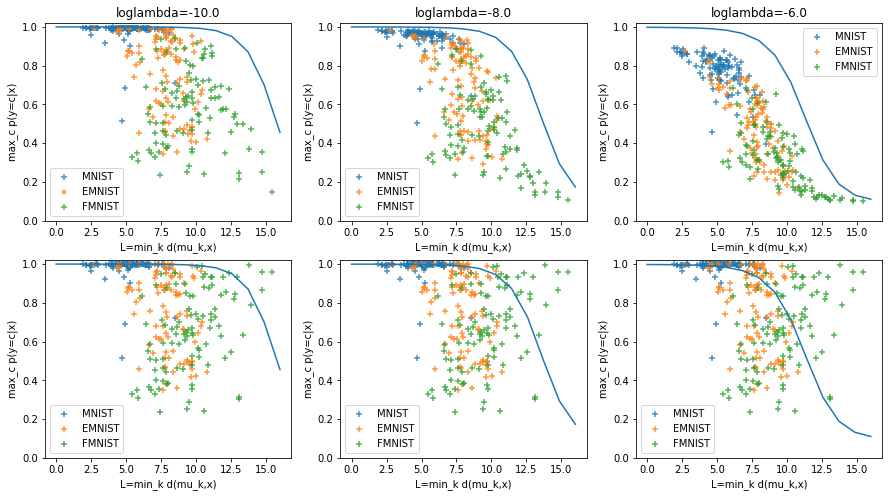

In [10]:
visualize_bound(gmm_model, [-10.,-8.,-6.])

In [29]:
def bound(L, model):
    xi = (model.mm.calculate_bound(L)-model.loglam).exp()
    return .1*(1+10*xi)/(1+xi)

def visualize_bound(model, lamv, xv=np.linspace(0., 16.,15)):
    with torch.no_grad():
        temp_lam = model.loglam.data
        n = 1
        data = []
        for _ in range(n):
            data.append(enumerate(dl.test_loader).__next__()[1][0])
        data_MNIST = torch.cat(data, dim=0)
        Lm = model.mm.metric.cpu()(data_MNIST.view(n*100,784)[:,None,:], dl.X_MNIST[None,:,:]).min(dim=1)[0]
              
        data = []
        for _ in range(n):
            data.append(enumerate(dl.EMNIST_train_loader).__next__()[1][0])
        data_EMNIST = torch.cat(data, dim=0)
        Le = model.mm.metric.cpu()(data_EMNIST.view(n*100,784)[:,None,:], dl.X_MNIST[None,:,:]).min(dim=1)[0]
        
        data = []
        for _ in range(n):
            data.append(enumerate(dl.fashion_train_loader).__next__()[1][0])
        data_FMNIST = torch.cat(data, dim=0)
        Lf = model.mm.metric.cpu()(data_FMNIST.view(n*100,784)[:,None,:], dl.X_MNIST[None,:,:]).min(dim=1)[0]
        
        model.mm.metric.cuda()
        plt.figure(figsize=(15,8))


        for i, lam in enumerate(lamv):
            plt.subplot(2,len(lamv),i+1)
            model.loglam.data = torch.tensor(lam, device=device)
            plt.plot(xv, [bound(x, model) for x in xv] )

            y = model(data_MNIST.to(device)).max(dim=1)[0].exp()
            ms = plt.scatter(Lm.detach(),y.detach().cpu().numpy(),alpha=.8, marker='+')

            y = model(data_EMNIST.to(device)).max(dim=1)[0].exp()
            es = plt.scatter(Le.detach(),y.detach().cpu().numpy(),alpha=.8, marker='+')

            y = model(data_FMNIST.to(device)).max(dim=1)[0].exp()
            fs = plt.scatter(Lf.detach(),y.detach().cpu().numpy(),alpha=.8, marker='+')
            
            plt.title('loglambda='+str(lam))
            plt.xlabel('L=min_k d(mu_k,x)')
            plt.ylabel('max_c p(y=c|x)')
            plt.legend(( ms, es, fs),
                       ('MNIST', 'EMNIST', 'FMNIST'))
            plt.ylim([0,1.02])
            plt.xlim([0,xv[-1]])
            
        for i, lam in enumerate(lamv):
            plt.subplot(2,len(lamv),i+1+len(lamv))
            model.loglam.data = torch.tensor(lam, device=device)
            plt.plot(xv, [bound(x, model) for x in xv] )

            y = model.base_model(data_MNIST.to(device)).max(dim=1)[0].exp()
            ms = plt.scatter(Lm.detach(),y.detach().cpu().numpy(),alpha=.8, marker='+')

            y = model.base_model(data_EMNIST.to(device)).max(dim=1)[0].exp()
            es = plt.scatter(Le.detach(),y.detach().cpu().numpy(),alpha=.8, marker='+')

            y = model.base_model(data_FMNIST.to(device)).max(dim=1)[0].exp()
            fs = plt.scatter(Lf.detach(),y.detach().cpu().numpy(),alpha=.8, marker='+')

            plt.xlabel('L=min_k d(mu_k,x)')
            plt.ylabel('max_c p(y=c|x)')
            plt.legend(( ms, es, fs),
                       ('MNIST', 'EMNIST', 'FMNIST'))
            plt.ylim([0,1.02])
            plt.xlim([0,xv[-1]])
        plt.show()
        model.loglam.data = temp_lam



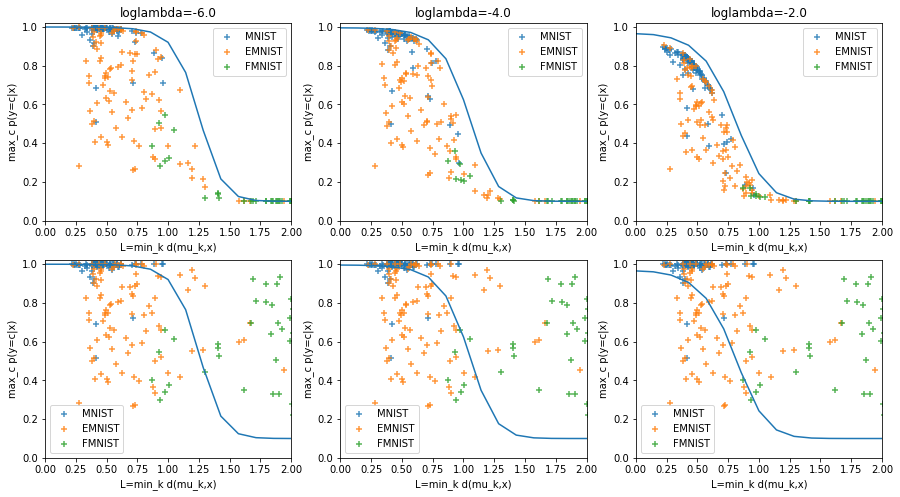

In [32]:
visualize_bound(pca, [-6.,-4.,-2.], xv=np.linspace(0., 2.,15))

In [14]:
pca = torch.load('SavedModels/gmm_model_pca.pth')